# When Graph Theory meets Computer Vision: Graph Cut Algorithm

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from PIL import Image
import io
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from ipywidgets import FileUpload, Button, VBox, Label
from collections import defaultdict
from collections import deque

## Simple Example - Same graph from lecture note

### 1. Compute the adjacency matrix  

In [2]:
data = np.array([
    [20, 20, 70],
    [10, 15, 70],
    [15, 70, 90]
])

rows, cols = data.shape
source = 0
sink = 10

# Map (i, j) → node 1-9
def node_id(i, j):
    return i * cols + j + 1

# Step 2: Initialize adjacency matrix for 11 nodes (0 to 10)
adj_matrix = np.zeros((11, 11))

# Step 3: Connect 4-connected neighbors among nodes 1-9
sigma = 30.0
for i in range(rows):
    for j in range(cols):
        u = node_id(i, j)
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols:
                v = node_id(ni, nj)
                diff = data[i,j] - data[ni,nj]
                weight = np.exp(-diff**2 / (2 * sigma**2))
                adj_matrix[u][v] = weight

# Step 4: Manually connect source and sink
adj_matrix[source][1] = 2  # source (0) to node 1
adj_matrix[9][sink] = 2    # node 9 to sink (10)
print("Adjacency Matrix:\n", adj_matrix)


Adjacency Matrix:
 [[0.         2.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.94595947 0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.24935221 0.         0.98620712
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.24935221 0.         0.         0.
  1.         0.         0.         0.         0.        ]
 [0.         0.94595947 0.         0.         0.         0.98620712
  0.         0.98620712 0.         0.         0.        ]
 [0.         0.         0.98620712 0.         0.98620712 0.
  0.18627046 0.         0.18627046 0.         0.        ]
 [0.         0.         0.         1.         0.         0.18627046
  0.         0.         0.         0.8007374  0.        ]
 [0.         0.         0.         0.         0.98620712 0.
  0.         0.         0.18627046 0.         0.        ]
 [0.         

### 2. Apply Ford-Fulkerson Algorithm to the adjacency matrix

In [3]:
def bfs(rGraph, s, t, parent):
    visited = [False] * len(rGraph)
    queue = deque([s])
    visited[s] = True

    while queue:
        u = queue.popleft()
        for v, capacity in enumerate(rGraph[u]):
            if not visited[v] and capacity > 0:
                queue.append(v)
                visited[v] = True
                parent[v] = u
                if v == t:
                    return True
    return False

def ford_fulkerson(graph, source, sink):
    rGraph = [row.copy() for row in graph]  # residual graph
    parent = [-1] * len(graph)
    max_flow = 0

    while bfs(rGraph, source, sink, parent):
        path_flow = float('inf')
        v = sink
        while v != source:
            u = parent[v]
            path_flow = min(path_flow, rGraph[u][v])
            v = parent[v]
        max_flow += path_flow

        v = sink
        while v != source:
            u = parent[v]
            rGraph[u][v] -= path_flow
            rGraph[v][u] += path_flow
            v = parent[v]

    return max_flow, rGraph

# Step 4: Run Ford-Fulkerson
max_flow, residual_graph = ford_fulkerson(adj_matrix, source, sink)

Plot the residual graph

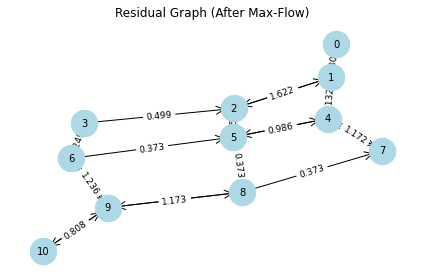

In [4]:
def plot_residual_graph(residual_graph):
    G_res = nx.DiGraph()
    num_nodes = len(residual_graph)

    # Add nodes
    for u in range(num_nodes):
        G_res.add_node(u)

    # Add edges with non-zero residual capacity
    for u in range(num_nodes):
        for v in range(num_nodes):
            cap = residual_graph[u][v]
            if cap > 1e-5:  # avoid tiny float errors
                G_res.add_edge(u, v, weight=round(cap, 3))

    # Create a layout
    pos = nx.spring_layout(G_res, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G_res, pos, node_color='lightblue', node_size=700)
    
    # Draw edges
    nx.draw_networkx_edges(G_res, pos, arrowstyle='->', arrowsize=20)

    # Draw labels
    nx.draw_networkx_labels(G_res, pos, font_size=10)

    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G_res, 'weight')
    nx.draw_networkx_edge_labels(G_res, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Residual Graph (After Max-Flow)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function after running Ford-Fulkerson
plot_residual_graph(residual_graph)


### Find the min-cit path 

In [5]:
def get_min_cut_edges(residual_graph, source):
    visited = [False] * len(residual_graph)
    queue = deque([source])
    visited[source] = True

    while queue:
        u = queue.popleft()
        for v, capacity in enumerate(residual_graph[u]):
            if capacity > 0 and not visited[v]:
                visited[v] = True
                queue.append(v)

    cut_edges = []
    for u in range(len(residual_graph)):
        for v in range(len(residual_graph)):
            if visited[u] and not visited[v] and adj_matrix[u][v] > 0:
                cut_edges.append((u, v))
    return cut_edges

cut_edges = get_min_cut_edges(residual_graph, source)

# Step 6: Output
np.set_printoptions(precision=3, suppress=True)
print("\nMaximum Flow:", round(max_flow, 3))
print("Min-Cut Edges:", cut_edges)


Maximum Flow: 0.808
Min-Cut Edges: [(2, 3), (5, 6), (5, 8), (7, 8)]


NetworkX library has built-in minimum_cut function 

In [6]:

G = nx.DiGraph()
for u in range(11):
    for v in range(11):
        if adj_matrix[u][v] > 0:
            G.add_edge(u, v, capacity=adj_matrix[u][v])

# Step 6: Compute min-cut
cut_value, partition = nx.minimum_cut(G, source, sink, capacity='capacity')
reachable, non_reachable = partition

# Step 7: Extract cut edges
cut_edges = []
for u in reachable:
    for v in G[u]:
        if v in non_reachable:
            cut_edges.append((u, v))

# Step 8: Show results
np.set_printoptions(precision=3, suppress=True)
print("Adjacency Matrix:\n", adj_matrix)
print("\nMinimum Cut Value:", round(cut_value, 3))
print("Cut Edges:", cut_edges)


Adjacency Matrix:
 [[0.    2.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.946 0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.249 0.    0.986 0.    0.    0.    0.    0.   ]
 [0.    0.    0.249 0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.946 0.    0.    0.    0.986 0.    0.986 0.    0.    0.   ]
 [0.    0.    0.986 0.    0.986 0.    0.186 0.    0.186 0.    0.   ]
 [0.    0.    0.    1.    0.    0.186 0.    0.    0.    0.801 0.   ]
 [0.    0.    0.    0.    0.986 0.    0.    0.    0.186 0.    0.   ]
 [0.    0.    0.    0.    0.    0.186 0.    0.186 0.    0.801 0.   ]
 [0.    0.    0.    0.    0.    0.    0.801 0.    0.801 0.    2.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]

Minimum Cut Value: 0.808
Cut Edges: [(2, 3), (5, 6), (5, 8), (7, 8)]


# User interactive example: Upload your own image!

## 1. Upload your own image

In [15]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


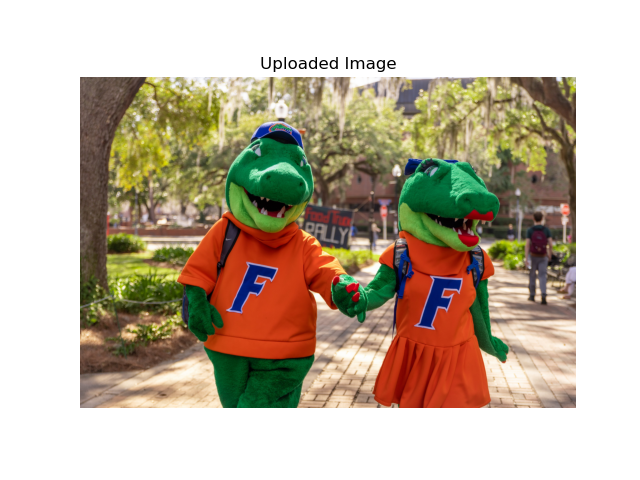

In [17]:
uploaded_image = None
uploader = FileUpload(accept='.jpg,.jpeg,.png', multiple=False)
label = Label("Upload an image")

def on_upload_change(change):
    global image
    for file_info in uploader.value:
        content = file_info['content']
        name = file_info['name']
        with open(name, 'wb') as f:
            f.write(content)
        image = cv2.imread(name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title("Uploaded Image")
        plt.axis('off')
        plt.show()

uploader.observe(on_upload_change, names='value')
display(VBox([label, uploader]))


## 2. Draw line on the image to indicate the foreground/background 

Foreground(Object): Red Line | Background: Blue Line

For the efficient computation, let's reduce the image resolution

In [18]:
def resize_image(image, max_size=128):
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    return cv2.resize(image, (int(w*scale), int(h*scale)))

image = resize_image(image, max_size=256)

<IPython.core.display.Javascript object>


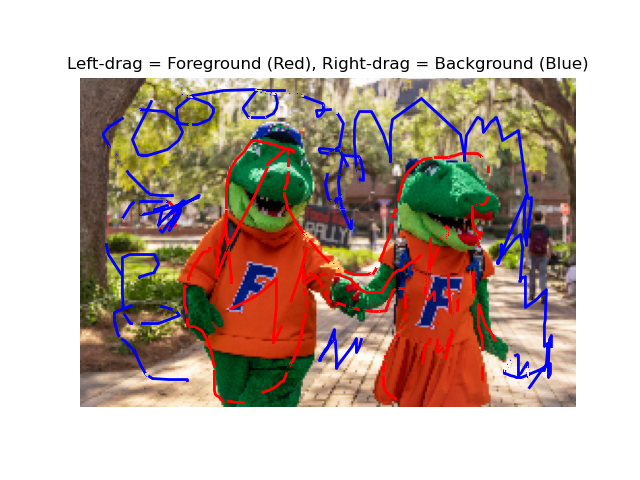

In [19]:
from matplotlib.lines import Line2D

foreground_lines = []
background_lines = []

def interactive_drawing(image):
    drawing = False
    current_line = None

    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Left-drag = Foreground (Red), Right-drag = Background (Blue)")
    plt.axis("off")

    def on_press(event):
        nonlocal drawing, current_line
        if event.inaxes != ax:
            return
        drawing = True
        color = 'red' if event.button == 1 else 'blue'
        current_line = Line2D([event.xdata], [event.ydata], color=color, linewidth=2)
        ax.add_line(current_line)
        fig.canvas.draw()

    def on_motion(event):
        nonlocal current_line
        if not drawing or event.inaxes != ax or current_line is None:
            return
        xdata, ydata = current_line.get_xdata(), current_line.get_ydata()
        current_line.set_xdata(np.append(xdata, event.xdata))
        current_line.set_ydata(np.append(ydata, event.ydata))
        fig.canvas.draw()

    def on_release(event):
        nonlocal drawing, current_line
        if current_line is None:
            return
        drawing = False
        coords = list(zip(current_line.get_xdata(), current_line.get_ydata()))
        coords = [(int(x), int(y)) for x, y in coords]

        if current_line.get_color() == 'red':
            foreground_lines.extend(coords)
        else:
            background_lines.extend(coords)

        current_line = None
        fig.canvas.draw()

    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)
    plt.show()

# Call this after image is uploaded
interactive_drawing(image)


## 3. Construct graph and apply Graph Cut to the drawn image 

In [20]:
def construct_graph_with_visuals(image, fg_points, bg_points):
    height, width = image.shape[:2]
    G = nx.DiGraph()

    def node(x, y): return y * width + x
    fg_set = set(fg_points)
    bg_set = set(bg_points)

    edge_weights = defaultdict(float)  # For visualization

    for y in range(height):
        for x in range(width):
            idx = node(x, y)
            G.add_node(idx)

            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx_, ny_ = x + dx, y + dy
                if 0 <= nx_ < width and 0 <= ny_ < height:
                    n_idx = node(nx_, ny_)
                    diff = np.linalg.norm(image[y, x].astype(np.float32) - image[ny_, nx_].astype(np.float32))
                    weight = np.exp(-diff / 25.0)
                    G.add_edge(idx, n_idx, capacity=weight)
                    edge_weights[(idx, n_idx)] = weight

            if (x, y) in fg_set:
                G.add_edge('source', idx, capacity=1e5)
            elif (x, y) in bg_set:
                G.add_edge(idx, 'sink', capacity=1e5)
            else:
                G.add_edge('source', idx, capacity=1.0)
                G.add_edge(idx, 'sink', capacity=1.0)

    return G, edge_weights


In [21]:
def visualize_graph_patch(image, edge_weights, patch_size=5):
    height, width = image.shape[:2]
    patch_img = image[:patch_size, :patch_size]
    fig, ax = plt.subplots()
    ax.imshow(patch_img)
    
    def node(x, y): return y * width + x

    for y in range(patch_size):
        for x in range(patch_size):
            idx = node(x, y)
            for dx, dy in [(1, 0), (0, 1)]:  # Right and Down
                nx_, ny_ = x + dx, y + dy
                if nx_ < patch_size and ny_ < patch_size:
                    n_idx = node(nx_, ny_)
                    weight = edge_weights.get((idx, n_idx), None)
                    if weight:
                        ax.plot([x, nx_], [y, ny_], 'y-', alpha=0.5)
                        mid_x, mid_y = (x + nx_) / 2, (y + ny_) / 2
                        ax.text(mid_x, mid_y, f"{weight:.2f}", fontsize=6, color='red')
    ax.set_title("Graph Edges + Weights (Small Patch)")
    plt.show()


In [22]:
def run_min_cut_and_draw(G, image):
    height, width = image.shape[:2]
    def node_to_coords(node): return (node % width, node // width)

    flow_value, (foreground, background) = nx.minimum_cut(G, 'source', 'sink')
    segmented = np.zeros((height, width), dtype=np.uint8)

    for node in foreground:
        if isinstance(node, int):
            x, y = node_to_coords(node)
            segmented[y, x] = 255

    # Optional: Draw cut boundary
    boundary_img = image.copy()
    for node in foreground:
        if isinstance(node, int):
            x, y = node_to_coords(node)
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx_, ny_ = x + dx, y + dy
                if 0 <= nx_ < width and 0 <= ny_ < height:
                    neighbor = ny_ * width + nx_
                    if neighbor in background:
                        boundary_img[y, x] = [255, 0, 255]  # Purple cut line

    return segmented, boundary_img


In [23]:
def show_results(original, segmented_mask, boundary_img):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(segmented_mask, cmap='gray')
    axs[1].set_title("Segmented Mask")
    axs[1].axis("off")

    axs[2].imshow(boundary_img)
    axs[2].set_title("Min-Cut Boundary Overlay")
    axs[2].axis("off")

    plt.show()


In [24]:
G, edge_weights = construct_graph_with_visuals(image, foreground_lines, background_lines)

Visualize the constructed graph from the drawn image

<IPython.core.display.Javascript object>


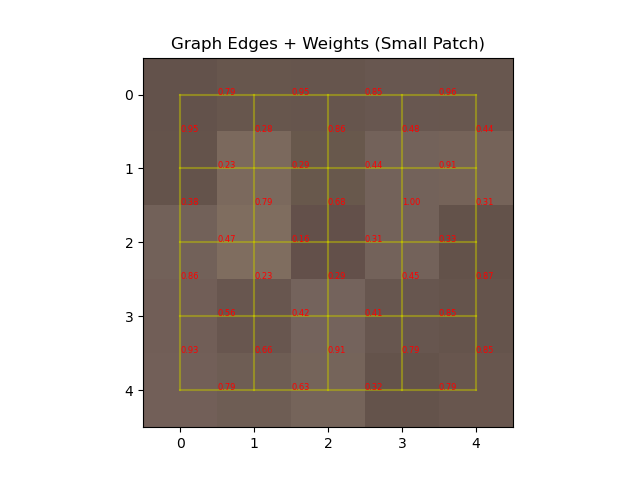

In [25]:
visualize_graph_patch(image, edge_weights, patch_size=5)

<IPython.core.display.Javascript object>


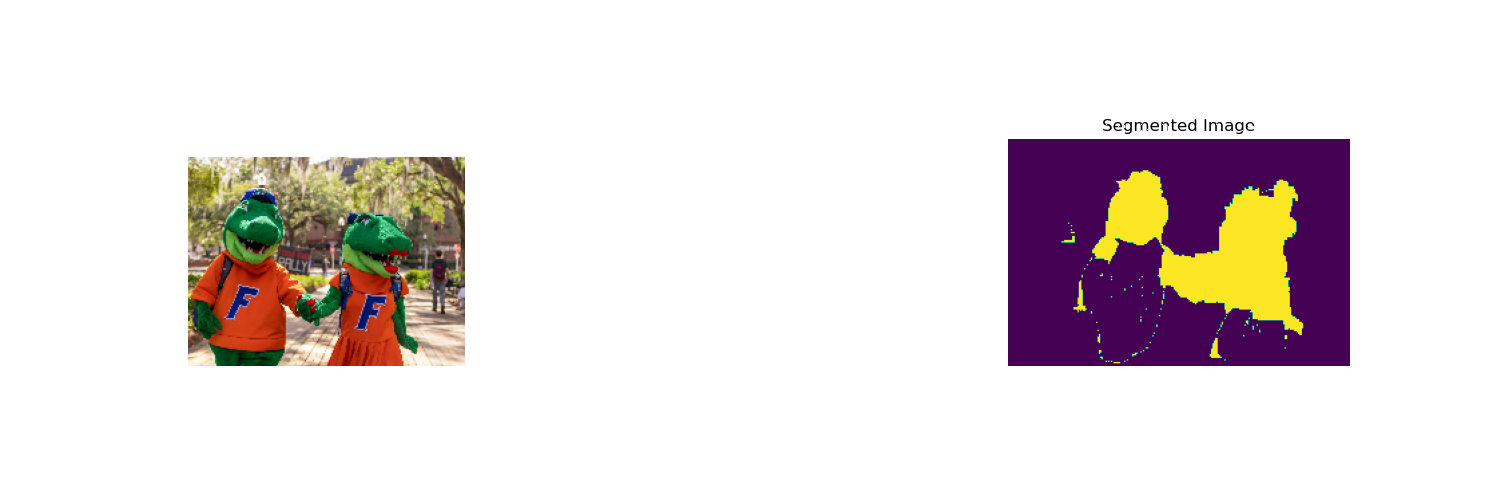

In [27]:
segmented_mask, boundary_overlay = run_min_cut_and_draw(G, image)
show_results(image, segmented_mask, boundary_overlay)

## Let's improve the segmentation performance using Grabcut algorithm 

### GrabCut improves segmentation result by applying Gaussian Mixture Model from the Graph Cut  

In [29]:
def apply_grabcut_from_lines(image, foreground_lines, background_lines, radius=3, iter_count=5):
    h, w = image.shape[:2]

    # Step 1: Prepare mask
    # 0 = sure background, 1 = sure foreground, 2 = probable background, 3 = probable foreground
    mask = np.full((h, w), cv2.GC_PR_BGD, dtype=np.uint8)  # start with "probably background"

    # Mark definite background and foreground
    for x, y in background_lines:
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(mask, (x, y), radius, cv2.GC_BGD, -1)

    for x, y in foreground_lines:
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(mask, (x, y), radius, cv2.GC_FGD, -1)

    # Step 2: Allocate models for GrabCut (required)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)

    # Step 3: Run GrabCut with mask
    cv2.grabCut(image, mask, None, bg_model, fg_model, iter_count, mode=cv2.GC_INIT_WITH_MASK)

    # Step 4: Extract final mask
    output_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    return output_mask

In [30]:
def show_grabcut_result(image, mask):
    segmented = image.copy()
    segmented[mask == 0] = 0

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("GrabCut Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented)
    plt.title("Segmented Object (GrabCut)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


<IPython.core.display.Javascript object>


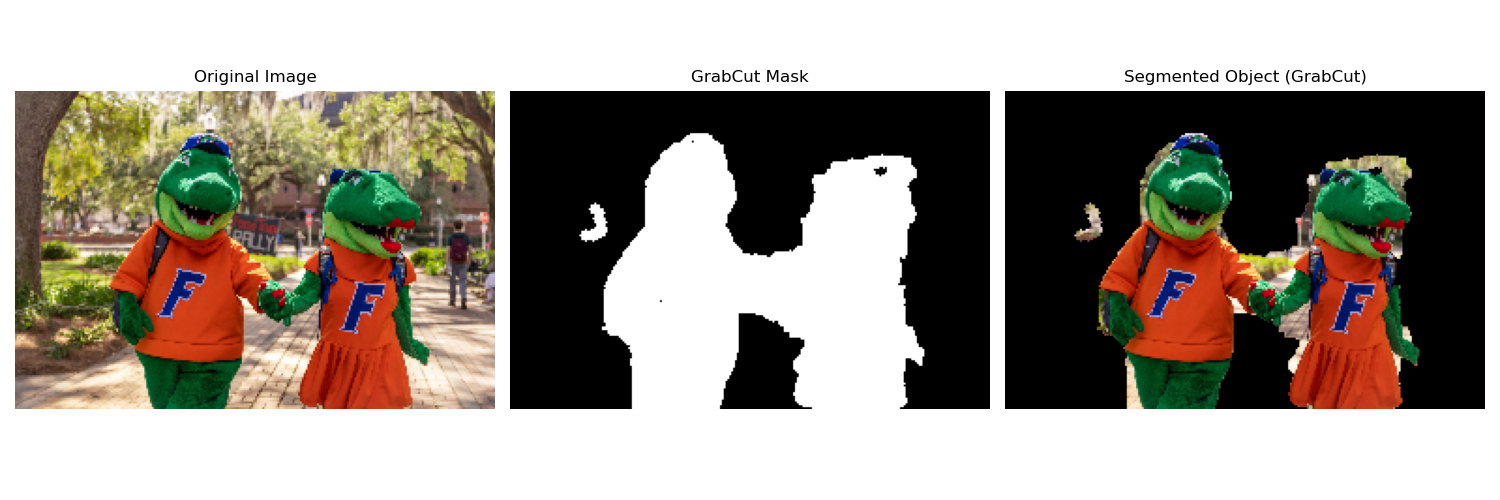

In [31]:
mask = apply_grabcut_from_lines(image, foreground_lines, background_lines)
show_grabcut_result(image, mask)
